# pvlib with PySAM financial model example
<img src="SAM-logo-horizontal.png"
     width= "500" />
<img src="pvlib_logo_horiz.png"
     width= "500" />
## Run pvlib modelchain, pass power and energy results to SAM financial models for technoeconomic analysis
## Steps:
### 1. Setup [pvlib](https://pvlib-python.readthedocs.io/en/stable/index.html)
### 2. Generate kW, kWh results from pvlib modelchain
### 3. Setup [PySAM](https://nrel-pysam.readthedocs.io/en/main/index.html), relevant financial parameters
### 4. Run battery model
### 5. Analyze powerflow with interconnection limits, different battery sizes

In [12]:
import pvlib

import pandas as pd

import matplotlib.pyplot as plt

#Salt Lake City coordinates and weather data
coordinates = [
    (35.106, -106.629, 'Albuquerque', 1619, 'Etc/GMT-7')
]



sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam(path="https://raw.githubusercontent.com/NREL/SAM/patch/deploy/libraries/CEC%20Inverters.csv")

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
modules_per_string = 28
strings_per_inverter = 400

inverter = sapm_inverters['Sungrow_Power_Supply_Co___Ltd___SC2500U__550V_']


temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [13]:
tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude, roll_utc_offset=-7)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

## PVLib ModelChain
- Run models as different objects
- More information at https://pvlib-python.readthedocs.io/en/stable/user_guide/introtutorial.html
- Represents one system irradiance to AC power. For multiple inverters feeding one interconnection, multiplying the output is the preferred solution (assuming identical power blocks and no transformer losses): https://github.com/pvlib/pvlib-python/discussions/1660

Albuquerque    5.211570e+06
dtype: float64
utc_time
1990-01-01 00:00:00-07:00   -62.8
1990-01-01 01:00:00-07:00   -62.8
1990-01-01 02:00:00-07:00   -62.8
1990-01-01 03:00:00-07:00   -62.8
1990-01-01 04:00:00-07:00   -62.8
                             ... 
1990-12-31 19:00:00-07:00   -62.8
1990-12-31 20:00:00-07:00   -62.8
1990-12-31 21:00:00-07:00   -62.8
1990-12-31 22:00:00-07:00   -62.8
1990-12-31 23:00:00-07:00   -62.8
Length: 8760, dtype: float64


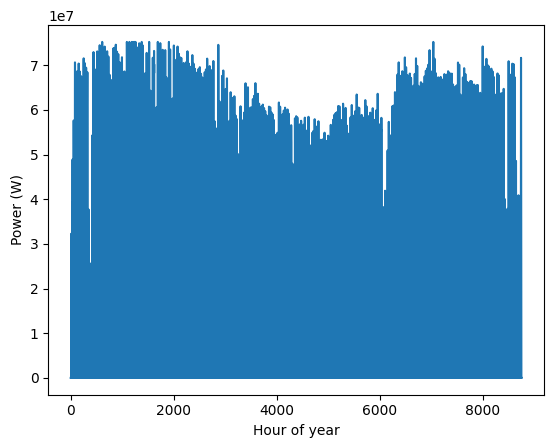

In [65]:
from pvlib.pvsystem import PVSystem, Array, FixedMount

from pvlib.location import Location

from pvlib.modelchain import ModelChain

energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
    )
    mount = FixedMount(surface_tilt=latitude, surface_azimuth=180)
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
        modules_per_string=modules_per_string,
        strings=strings_per_inverter
    )
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    mc = ModelChain(system, location)
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum() #AC power series
    energies[name] = annual_energy


energies = pd.Series(energies)/1000

print(energies)
print(mc.results.ac)

number_of_power_blocks = 30

plt.plot(range(0,8760,1), mc.results.ac * number_of_power_blocks)
plt.xlabel('Hour of year')
plt.ylabel('Power (W)')

export_units = pd.Series(mc.results.ac / 1000 * number_of_power_blocks)
export_units.to_csv("PV_production.csv")

## SAM Battery Model
- Front of meter, AC coupled battery with interonnection limit
- Battery needs financial data to use automated dispatch
- Setup inputs in desktop tool, export [PySAM JSON's](https://nrel-pysam.readthedocs.io/en/main/getting-started.html#example-1-build-a-model-from-sam), iterate in PySAM


In [129]:
import json
import PySAM.Battery as bt # import the PVWatts module from PySAM

# create a new instance of the battery module
batt = bt.new()

#Setup model in SAM, export JSON files with inputs
#For more information on PySAM input json's, see https://nrel-pysam.readthedocs.io/en/main/getting-started.html

#Alternatively, start with default inputs to battery model (may not be accurate for your case)

batt = bt.default("CustomGenerationBatterySingleOwner")


# get the inputs from the JSON file
with open('Battery_pvlib_example_battery.json', 'r') as f:
        so_inputs = json.load( f )

# iterate through the input key-value pairs and set the module inputs
for k, v in so_inputs.items():
    if k != 'number_inputs':
        batt.value(k, v)

## Generation input to battery model
- Battery model needs timeseries power production for the lifetime of the system (kWAC)
- Set system_use_lifetime_output to 0 for single year of results, this will degrade the PV and battery together

In [130]:
# Apply AC degradation to generate lifetime array
full_timeseries_w_degradation = []
 # / 1000 -> kWAC, 30 power blocks
single_year_scaled = mc.results.ac / 1000 * number_of_power_blocks
analysis_period = 25 # Years
degradation_per_year = 0.005 # %/year, applied linearly
for i in range(0, analysis_period):
    full_timeseries_w_degradation.extend((single_year_scaled * (1 - i * degradation_per_year)).to_list())

## Optional: resize battery
- JSON file has a four-hour battery
- The cell below gives the option to change the battery size in Python

In [135]:
from PySAM.BatteryTools import battery_model_sizing
battery_kw = 60000
battery_kwh = battery_kw * 1
battery_voltage = 500

battery_model_sizing(batt, battery_kw, battery_kwh, battery_voltage)

In [ ]:
# Assign key battery inputs (these are independent of size)
# Note: batt.SystemOutput.gen is an in-out. Make sure to any re-runs include this cell to avoid using the modified input
batt.SystemOutput.gen = full_timeseries_w_degradation
batt.Lifetime.system_use_lifetime_output = 1
batt.Lifetime.analysis_period = analysis_period

batt.GridLimits.enable_interconnection_limit = 1 # 1 == on
batt.GridLimits.grid_interconnection_limit_kwac = 60000

batt.BatteryDispatch.batt_dispatch_choice = 0 # Automated dispatch
batt.BatteryDispatch.batt_dispatch_auto_can_charge = 0 # Restrict ability to charge from PV any time it is generating
batt.BatteryDispatch.batt_dispatch_auto_can_curtailcharge = 1 # Only charge from energy that would be curtailed

In [137]:
batt.execute() #Run model


## Results
- Lifetime generation with battery
- Compare a few days of generation vs PV only
- Check SOC for battery utilization
- Check lifetime parameters

Text(0, 0.5, 'Power (kW)')

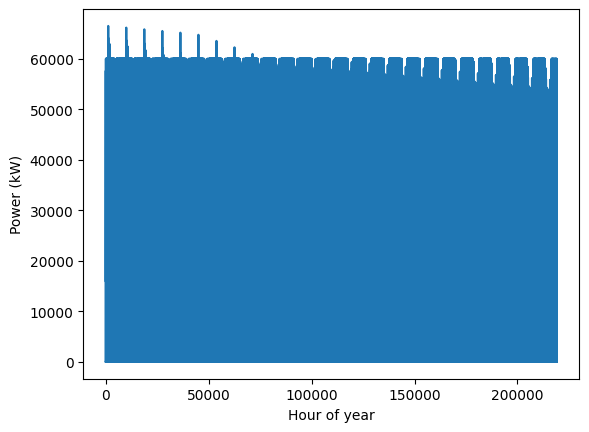

In [ ]:
plt.plot(range(0,8760 * 25,1), batt.SystemOutput.gen[0:8760 * 25])
plt.xlabel('Hour of year')
plt.ylabel('Power (kW)')

Text(0, 0.5, 'Power (kW)')

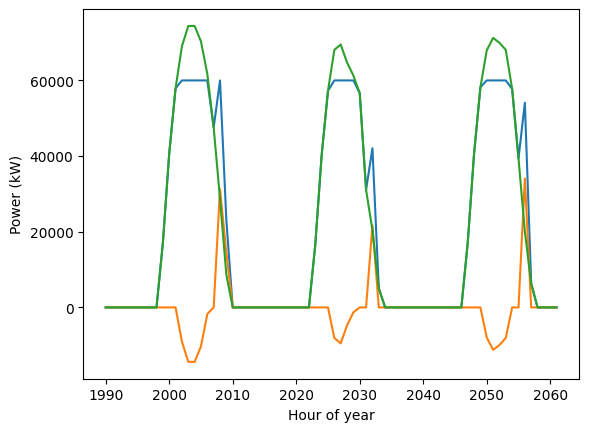

In [134]:
plt.plot(range(1990,2062,1), batt.SystemOutput.gen[1990:2062])
plt.plot(range(1990,2062,1), batt.Outputs.batt_power[1990:2062])
plt.plot(range(1990,2062,1), export_units[1990:2062])
plt.xlabel('Hour of year')
plt.ylabel('Power (kW)')

Text(0, 0.5, 'Battery SOC (%)')

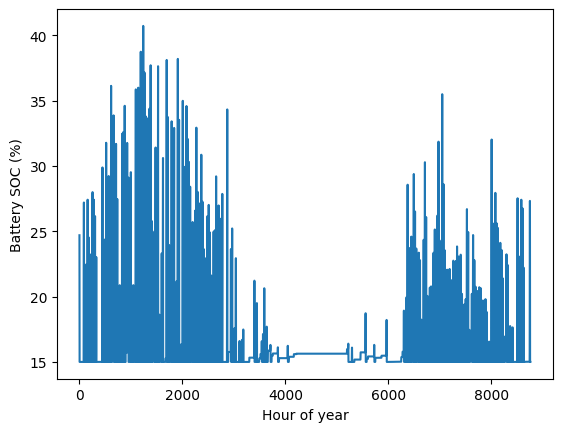

In [123]:
plt.plot(range(0,8760,1), batt.Outputs.batt_SOC[0:8760])
plt.xlabel('Hour of year')
plt.ylabel('Battery SOC (%)')

Text(0, 0.5, 'Battery capacity as percent of nameplate (%)')

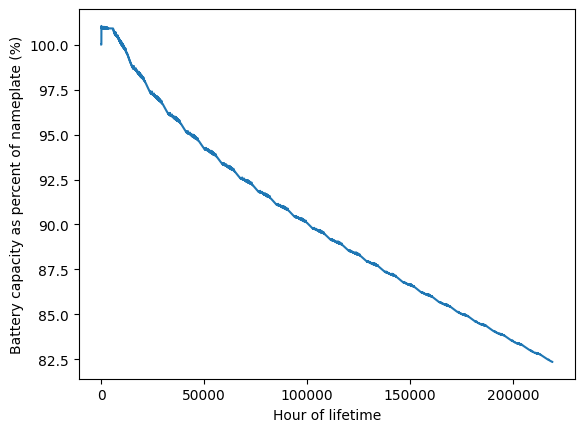

In [125]:
plt.plot(range(0,8760 * 25,1), batt.Outputs.batt_capacity_percent[0:8760 * 25])
plt.xlabel('Hour of lifetime')
plt.ylabel('Battery capacity as percent of nameplate (%)')